__Imports__

In [1]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
import random

### __Data Preprocessing__

In [2]:
jokes_df = pd.read_excel('./data/jester-data-1.xls', sheet_name='jester-data-1-new')

In [3]:
jokes_df.index = [f'user_{i}' for i in range(len(jokes_df))]
jokes_df.columns = ['total'] + [f'J{i}' for i in range(1, 101)]

In [4]:
jokes_df = jokes_df.replace(99.0, np.nan)

In [5]:
jokes_df

,total,J1,J2,J3,J4,J5,J6,J7,J8,J9,...,J91,J92,J93,J94,J95,J96,J97,J98,J99,J100
user_0,100.0,4.08,-0.29,6.36,4.37,-2.38,-9.66,-0.73,-5.34,8.88,...,2.82,-4.95,-0.29,7.86,-0.19,-2.14,3.06,0.34,-4.32,1.07
user_1,49.0,NaN,NaN,NaN,NaN,9.03,9.27,9.03,9.27,NaN,...,NaN,NaN,NaN,9.08,NaN,NaN,NaN,NaN,NaN,NaN
user_2,48.0,NaN,8.35,NaN,NaN,1.80,8.16,-2.82,6.21,NaN,...,NaN,NaN,NaN,0.53,NaN,NaN,NaN,NaN,NaN,NaN
user_3,91.0,8.50,4.61,-4.17,-5.39,1.36,1.60,7.04,4.61,-0.44,...,5.19,5.58,4.27,5.19,5.73,1.55,3.11,6.55,1.80,1.60
user_4,100.0,-6.17,-3.54,0.44,-8.50,-7.09,-4.32,-8.69,-0.87,-6.65,...,-3.54,-6.89,-0.68,-2.96,-2.18,-3.35,0.05,-9.08,-5.05,-3.45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
user_24977,100.0,0.44,7.43,9.08,2.33,3.20,6.75,-8.79,-0.53,-8.74,...,8.83,-1.21,9.22,-6.70,8.45,9.03,6.55,8.69,8.79,7.43
user_24978,91.0,9.13,-8.16,8.59,9.08,0.87,-8.93,-3.50,5.78,-8.11,...,-1.17,-5.73,-1.46,0.24,9.22,-8.20,-7.23,-8.59,9.13,8.45
user_24979,39.0,NaN,NaN,NaN,NaN,-7.77,NaN,6.70,-6.75,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
user_24980,37.0,NaN,NaN,NaN,NaN,-9.71,NaN,4.56,-8.30,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The sub-matrix including only __columns {5, 7, 8, 13, 15, 16, 17, 18, 19, 20} is dense__. Almost all users have rated those jokes.

In [6]:
sub_df = jokes_df.iloc[:, [5, 7, 8, 13, 15, 16, 17, 18, 19, 20]]
sub_df

,J5,J7,J8,J13,J15,J16,J17,J18,J19,J20
user_0,-2.38,-0.73,-5.34,4.42,4.56,-0.97,4.66,-0.68,3.30,-1.21
user_1,9.03,9.03,9.27,9.37,-6.36,-6.89,-7.86,9.03,9.03,9.03
user_2,1.80,-2.82,6.21,6.31,-7.23,-6.65,1.17,-6.60,-3.64,-2.09
user_3,1.36,7.04,4.61,-3.93,-2.33,-9.66,2.72,-1.36,2.57,4.51
user_4,-7.09,-8.69,-0.87,-5.00,0.49,-8.93,-3.69,-2.18,-2.28,-6.12
...,...,...,...,...,...,...,...,...,...,...
user_24977,3.20,-8.79,-0.53,-7.14,-3.50,-8.20,-3.98,-9.22,-0.15,-6.46
user_24978,0.87,-3.50,5.78,-7.48,-1.75,6.60,3.54,1.50,7.67,-0.44
user_24979,-7.77,6.70,-6.75,-6.46,-6.80,-6.41,-6.99,7.23,6.75,-6.99
user_24980,-9.71,4.56,-8.30,-9.47,3.45,-0.92,-4.51,-4.13,-5.73,-9.51


We employ __Collaborative Filtering__ using
### __Autoencoders for Collaborative Filtering__

In [7]:
def process_data():
    # Config
    holdouts_per_user = 4
    random.seed(42)
    np.random.seed(42)

    # Load Excel, skip the first column (num_rated)
    df = pd.read_excel('jester-data-1.xls', header=None)
    df.index = [f'user_{i}' for i in range(len(df))]
    df.columns = ['total'] + [f'J{i}' for i in range(1, 101)]

    # Adjust for zero indexing
    df = df.replace(99.0, np.nan)
    sub_df = df.iloc[:, [5, 7, 8, 13, 15, 16, 17, 18, 19, 20]]

    # Prepare training matrix and holdouts
    train_matrix = sub_df.copy()
    holdout_list = []

    for user_id in train_matrix.index:
        user_ratings = train_matrix.loc[user_id]

        # Valid jokes are the ones this user rated (not NaN)
        valid_jokes = user_ratings.dropna().index.tolist()

        if len(valid_jokes) <= holdouts_per_user:
            continue

        # Randomly choose holdouts
        holdout_jokes = np.random.choice(valid_jokes, size=holdouts_per_user, replace=False)

        for joke_id in holdout_jokes:
            true_rating = train_matrix.at[user_id, joke_id]
            holdout_list.append((user_id, joke_id, true_rating))
            train_matrix.at[user_id, joke_id] = np.nan  # Mask the rating

    return sub_df, train_matrix, holdout_list

In [8]:
def simulate_missing_values(inputs, masks, val_fraction=0.1, seed=42):
    np.random.seed(seed)
    mask_np = masks.numpy()
    input_np = inputs.numpy()
    
    train_mask = mask_np.copy()
    val_mask = np.zeros_like(mask_np)
    val_truth = np.full_like(input_np, np.nan)

    for i in range(mask_np.shape[0]):
        rated_indices = np.where(mask_np[i] == 1)[0]
        if len(rated_indices) < 2:
            continue
        val_size = max(1, int(len(rated_indices) * val_fraction))
        val_indices = np.random.choice(rated_indices, size=val_size, replace=False)
        train_mask[i, val_indices] = 0
        val_mask[i, val_indices] = 1
        val_truth[i, val_indices] = input_np[i, val_indices]

    # ✅ Replace NaNs in val_truth so PyTorch loss doesn't break
    val_truth = np.nan_to_num(val_truth, nan=0.0)

    return (
        torch.tensor(train_mask).float(), 
        torch.tensor(val_mask).float(), 
        torch.tensor(val_truth).float()
    )


In [9]:
# Copy your dense joke subset
data = sub_df.copy()

# Save mask of known ratings
mask = ~data.isna()

# Row-wise mean (only on rated jokes)
user_means = data.mean(axis=1)

# Center ratings: subtract mean where not NaN
normalized_data = data.sub(user_means, axis=0)

# Fill NaNs with 0 (neutral input for masked loss)
input_data = normalized_data.fillna(0).values.astype(np.float32)
inputs = torch.tensor(input_data)
masks = torch.tensor(mask.values.astype(np.float32))

# Split known ratings into train and validation
train_mask, val_mask, val_truth = simulate_missing_values(inputs, masks, val_fraction=0.1)

In [10]:
def add_noise(x, mask, dropout_rate=0.3):
    noise_mask = (torch.rand(x.shape) > dropout_rate).float()
    noisy_input = x * noise_mask * mask  # only mask known values
    return noisy_input

In [11]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim=10):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim)
        )

    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        return out

In [12]:
def masked_mse_loss(preds, targets, mask):
    diff = (preds - targets) * mask
    mse = torch.sum(diff ** 2) / torch.sum(mask)
    return mse

def train_autoencoder_with_latent_dim(inputs, masks, latent_dim, num_epochs=100, verbose=True):
    # Create simulated validation split
    train_mask, val_mask, val_truth = simulate_missing_values(inputs, masks, val_fraction=0.1)

    model = Autoencoder(input_dim=inputs.shape[1], latent_dim=latent_dim)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    train_losses = []
    val_rmses = []

    for epoch in range(num_epochs):
        model.train()

        # Add denoising noise only to the known training values
        noisy_inputs = add_noise(inputs, train_mask, dropout_rate=0.3)
        preds = model(noisy_inputs)

        # Train loss on known training ratings only
        train_loss = masked_mse_loss(preds, inputs, train_mask)

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        train_rmse = train_loss.sqrt().item()
        train_losses.append(train_rmse)

        # Validation RMSE on simulated missing values
        model.eval()
        with torch.no_grad():
            val_preds = model(inputs)
            val_rmse = masked_mse_loss(val_preds, val_truth, val_mask).sqrt().item()
            val_rmses.append(val_rmse)

        if verbose and epoch % 10 == 0:
            print(f"[Latent {latent_dim}] Epoch {epoch}, Train RMSE: {train_rmse:.4f}, Val RMSE: {val_rmse:.4f}")

    return model, train_losses, val_rmses

[Latent 50] Epoch 0, Train RMSE: 4.3923, Val RMSE: 4.3879
[Latent 50] Epoch 10, Train RMSE: 4.2408, Val RMSE: 4.1668
[Latent 50] Epoch 20, Train RMSE: 3.9472, Val RMSE: 3.8171
[Latent 50] Epoch 30, Train RMSE: 3.5755, Val RMSE: 3.2793
[Latent 50] Epoch 40, Train RMSE: 3.1020, Val RMSE: 2.5977
[Latent 50] Epoch 50, Train RMSE: 2.7745, Val RMSE: 1.9049
[Latent 50] Epoch 60, Train RMSE: 2.5738, Val RMSE: 1.4976
[Latent 50] Epoch 70, Train RMSE: 2.4321, Val RMSE: 1.1011
[Latent 50] Epoch 80, Train RMSE: 2.3606, Val RMSE: 0.7754
[Latent 50] Epoch 90, Train RMSE: 2.3564, Val RMSE: 0.6928
[Latent 50] Epoch 100, Train RMSE: 2.3240, Val RMSE: 0.6438
[Latent 50] Epoch 110, Train RMSE: 2.3334, Val RMSE: 0.6438
[Latent 50] Epoch 120, Train RMSE: 2.3189, Val RMSE: 0.6274
[Latent 50] Epoch 130, Train RMSE: 2.3100, Val RMSE: 0.5897
[Latent 50] Epoch 140, Train RMSE: 2.3084, Val RMSE: 0.6223
[Latent 50] Epoch 150, Train RMSE: 2.3036, Val RMSE: 0.6268
[Latent 50] Epoch 160, Train RMSE: 2.2973, Val RMSE

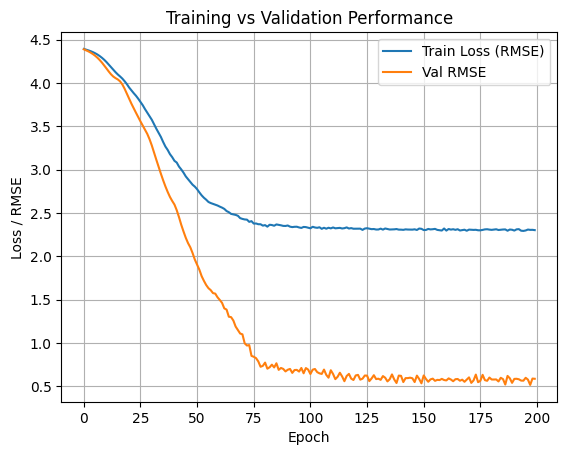

In [13]:
import matplotlib.pyplot as plt

model, train_losses, val_rmses = train_autoencoder_with_latent_dim(inputs, masks, num_epochs=200, latent_dim=50)

plt.plot(train_losses, label="Train Loss (RMSE)")
plt.plot(val_rmses, label="Val RMSE")
plt.xlabel("Epoch")
plt.ylabel("Loss / RMSE")
plt.legend()
plt.title("Training vs Validation Performance")
plt.grid(True)
plt.show()

In [14]:
model.eval()
with torch.no_grad():
    reconstructed = model(inputs).numpy()

# Add user mean back (broadcasting works due to shape)
reconstructed += user_means.values[:, np.newaxis]

# Build prediction DataFrame
reconstructed_df = pd.DataFrame(reconstructed, index=sub_df.index, columns=sub_df.columns)

# Select rows with NaNs
rows_with_nans = sub_df[sub_df.isna().any(axis=1)]
reconstructed_nans = reconstructed_df.loc[rows_with_nans.index]

# Show original NaNs and predicted values
for idx in rows_with_nans.index[:5]:  # Limit output
    print(f"\nUser: {idx}")
    print("Original (NaNs):")
    print(rows_with_nans.loc[idx])
    print("Reconstructed (Predicted):")
    print(reconstructed_nans.loc[idx])


User: user_236
Original (NaNs):
J5      NaN
J7    -9.47
J8     3.69
J13   -3.88
J15   -9.32
J16   -9.76
J17   -1.94
J18   -0.10
J19   -9.27
J20   -7.04
Name: user_236, dtype: float64
Reconstructed (Predicted):
J5     -4.144792
J7     -9.608658
J8      3.983772
J13    -3.834728
J15    -9.080794
J16   -10.709199
J17    -1.239901
J18    -0.620477
J19    -9.306213
J20    -7.961729
Name: user_236, dtype: float32

User: user_1185
Original (NaNs):
J5    -8.83
J7    -4.08
J8    -5.05
J13   -0.24
J15     NaN
J16   -2.86
J17   -3.83
J18   -8.69
J19   -6.02
J20   -8.74
Name: user_1185, dtype: float64
Reconstructed (Predicted):
J5    -8.740679
J7    -4.140086
J8    -4.263841
J13    0.037253
J15   -5.215205
J16   -3.544382
J17   -3.782852
J18   -8.578892
J19   -6.171777
J20   -9.106687
Name: user_1185, dtype: float32

User: user_1551
Original (NaNs):
J5     0.73
J7    -8.30
J8    -1.89
J13    0.73
J15   -2.04
J16     NaN
J17   -8.50
J18    1.21
J19    1.80
J20   -9.32
Name: user_1551, dtype: float

In [15]:
rows_with_nans

,J5,J7,J8,J13,J15,J16,J17,J18,J19,J20
user_236,NaN,-9.47,3.69,-3.88,-9.32,-9.76,-1.94,-0.10,-9.27,-7.04
user_1185,-8.83,-4.08,-5.05,-0.24,NaN,-2.86,-3.83,-8.69,-6.02,-8.74
user_1551,0.73,-8.30,-1.89,0.73,-2.04,NaN,-8.50,1.21,1.80,-9.32
user_1590,5.97,-2.52,-8.40,-7.04,-0.15,4.51,NaN,1.70,-3.98,3.25
user_2219,8.79,0.44,NaN,-6.75,-6.80,3.79,-9.51,2.82,8.50,-3.20
user_2689,0.44,2.96,NaN,8.11,3.45,3.30,4.51,2.96,2.86,2.91
user_2843,3.06,NaN,-4.42,8.54,-6.89,-9.27,1.12,4.51,-9.47,3.54
user_3459,8.74,8.64,-1.55,3.50,3.35,3.79,-1.60,0.68,NaN,4.13
user_3591,9.22,-0.87,-9.95,5.44,-9.61,-9.90,NaN,-9.95,4.56,7.18
user_3960,3.16,-7.82,-9.03,NaN,-6.31,-6.50,-1.89,-8.88,-5.19,1.31


In [16]:
reconstructed_nans

,J5,J7,J8,J13,J15,J16,J17,J18,J19,J20
user_236,-4.144792,-9.608658,3.983772,-3.834728,-9.080794,-10.709199,-1.239901,-0.620477,-9.306213,-7.961729
user_1185,-8.740679,-4.140086,-4.263841,0.037253,-5.215205,-3.544382,-3.782852,-8.578892,-6.171777,-9.106687
user_1551,0.986503,-8.939393,-1.827101,0.864111,-1.957247,-3.442827,-8.638297,1.683740,1.500116,-8.853760
user_1590,6.230008,-1.684527,-9.128416,-7.298137,-0.477925,4.056812,-1.400329,1.830798,-2.538424,2.622973
user_2219,9.043795,0.327859,-0.984418,-7.725275,-7.439145,3.377311,-9.241183,3.222323,9.140686,-2.090839
user_2689,0.408633,3.166887,3.837128,8.357424,3.544673,2.451891,4.618359,3.062869,3.087958,2.730869
user_2843,4.489786,-0.591602,-3.770863,9.216269,-7.767481,-10.036686,1.134215,3.084605,-8.762051,2.435604
user_3459,9.072213,8.980288,-1.761322,2.913684,2.845788,2.405442,-1.176773,1.274673,4.057320,4.219720
user_3591,9.202512,-0.032202,-10.133191,4.747790,-9.624496,-10.688680,-2.006428,-9.764361,5.054335,7.676866
user_3960,3.561337,-7.400645,-8.622128,-5.487756,-6.968635,-7.433268,-1.779680,-8.995793,-4.218775,1.545690
